E4. 네이버 영화리뷰 감성분석 도전하기
===
---
네번째 프로젝트: 다양한 모델들을 통하여 한국어 텍스트의 감성분석을 진행해보자!

![naver_movie](https://user-images.githubusercontent.com/70703320/104560678-911c6e80-5689-11eb-9e68-ddd3284e061b.png)

데이터 : [네이버 영화리뷰](https://github.com/e9t/nsmc)

---

### 프로젝트 진행 순서
* 1. 데이터 준비와 확인
* 2. 데이터로더 구성
* 3. 모델구성을 위한 데이터 분석 및 가공
* 4. 모델구성 및 validation set 구성
* 5. 모델 훈련 개시
* 6. Loss, Accuracy 그래프 시각화
* 7. 학습된 Embedding 레이어 분석
* 8. 한국어 Word2Vec 임베딩 활용하여 성능개선

---

## 1. 데이터 준비와 확인

### 1) 필요한 라이브러리 실행



In [1]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

### 2) 데이터 읽어들이고 확인

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더 구성

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어 (Stopwrods)제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index리턴

### 1) Mecab 불러오기

In [3]:
from konlpy.tag import Mecab
tokenizer = Mecab()

### 2) 데이터 로더 구성함수 

In [4]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 

    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) 
        temp_X = [word for word in temp_X if not word in stopwords] 
        X_test.append(temp_X)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]

    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

### 3) 단어 인덱싱

In [5]:
index_to_word = {index:word for word, index in word_to_index.items()}

### 4) decode 함수

In [6]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델구성을 위한 데이터 분석 및 가공

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 1) 데이터셋 내 문장 길이 분포

In [7]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))


문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092


### 2) 적절한 최대 문장 길이 지정

In [8]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 3) keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [9]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', 
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', 
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4. 모델구성 및 validation set 구성

In [10]:
vocab_size = 10000    
word_vector_dim = 16  

#### 1) 모델 0

In [11]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


#### 2) 모델 1

In [12]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.Conv1D(1024, 7, activation='relu'))
model1.add(keras.layers.MaxPooling1D(5))
model1.add(keras.layers.Conv1D(512, 7, activation='relu'))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(128, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid')) 

model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 1024)        115712    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 1024)        0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 512)         3670528   
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

#### 3) 모델 2

In [13]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  

model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 훈련 개시

In [14]:
X_val = X_train[:10000]   
y_val = y_train[:10000]

partial_X_train = X_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


#### 1) 모델 0

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/8
266/266 [==============================] - 2s 7ms/step - loss: 0.5361 - accuracy: 0.7590 - val_loss: 0.4250 - val_accuracy: 0.8396
Epoch 2/8
266/266 [==============================] - 2s 6ms/step - loss: 0.3614 - accuracy: 0.8523 - val_loss: 0.3456 - val_accuracy: 0.8508
Epoch 3/8
266/266 [==============================] - 1s 5ms/step - loss: 0.3222 - accuracy: 0.8659 - val_loss: 0.3368 - val_accuracy: 0.8527
Epoch 4/8
266/266 [==============================] - 1s 5ms/step - loss: 0.3064 - accuracy: 0.8733 - val_loss: 0.3375 - val_accuracy: 0.8548
Epoch 5/8
266/266 [==============================] - 1s 5ms/step - loss: 0.2957 - accuracy: 0.8779 - val_loss: 0.3375 - val_accuracy: 0.8568
Epoch 6/8
266/266 [==============================] - 2s 6ms/step - loss: 0.2848 - accuracy: 0.8832 - val_loss: 0.3435 - val_accuracy: 0.8560
Epoch 7/8
266/266 [==============================] - 1s 6ms/step - loss: 0.2729 - accuracy: 0.8890 - val_loss: 0.3436 - val_accuracy: 0.8538
Epoch 8/8
266

##### epoch에 따른 그래프를 그려볼 수 있는 항목들

In [16]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


#### 2) 모델 1

In [17]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=8  

history1 = model1.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=512,
                     validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/8
266/266 [==============================] - 16s 62ms/step - loss: 0.4019 - accuracy: 0.8084 - val_loss: 0.3300 - val_accuracy: 0.8552
Epoch 2/8
266/266 [==============================] - 7s 27ms/step - loss: 0.2960 - accuracy: 0.8765 - val_loss: 0.3208 - val_accuracy: 0.8603
Epoch 3/8
266/266 [==============================] - 7s 27ms/step - loss: 0.2504 - accuracy: 0.8988 - val_loss: 0.3325 - val_accuracy: 0.8623
Epoch 4/8
266/266 [==============================] - 7s 28ms/step - loss: 0.2033 - accuracy: 0.9216 - val_loss: 0.3560 - val_accuracy: 0.8577
Epoch 5/8
266/266 [==============================] - 7s 27ms/step - loss: 0.1582 - accuracy: 0.9415 - val_loss: 0.4278 - val_accuracy: 0.8523
Epoch 6/8
266/266 [==============================] - 7s 27ms/step - loss: 0.1207 - accuracy: 0.9567 - val_loss: 0.4848 - val_accuracy: 0.8469
Epoch 7/8
266/266 [==============================] - 7s 27ms/step - loss: 0.0986 - accuracy: 0.9654 - val_loss: 0.5066 - val_accuracy: 0.8495
Epoch

##### epoch에 따른 그래프를 그려볼 수 있는 항목들

In [18]:
history1_dict = history1.history
print(history1_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


#### 3) 모델 2

In [19]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
               metrics=['accuracy'])
              
epochs=8 

history2 = model2.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=512,
                     validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/8
266/266 [==============================] - 1s 4ms/step - loss: 0.5952 - accuracy: 0.7584 - val_loss: 0.4458 - val_accuracy: 0.8171
Epoch 2/8
266/266 [==============================] - 1s 3ms/step - loss: 0.3881 - accuracy: 0.8346 - val_loss: 0.3633 - val_accuracy: 0.8406
Epoch 3/8
266/266 [==============================] - 1s 3ms/step - loss: 0.3353 - accuracy: 0.8568 - val_loss: 0.3500 - val_accuracy: 0.8459
Epoch 4/8
266/266 [==============================] - 1s 3ms/step - loss: 0.3089 - accuracy: 0.8705 - val_loss: 0.3466 - val_accuracy: 0.8483
Epoch 5/8
266/266 [==============================] - 1s 3ms/step - loss: 0.2898 - accuracy: 0.8799 - val_loss: 0.3487 - val_accuracy: 0.8479
Epoch 6/8
266/266 [==============================] - 1s 4ms/step - loss: 0.2748 - accuracy: 0.8867 - val_loss: 0.3533 - val_accuracy: 0.8478
Epoch 7/8
266/266 [==============================] - 1s 4ms/step - loss: 0.2622 - accuracy: 0.8927 - val_loss: 0.3582 - val_accuracy: 0.8474
Epoch 8/8
266

##### epoch에 따른 그래프를 그려볼 수 있는 항목들

In [20]:
history2_dict = history2.history
print(history2_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


## 6. Loss, Accuracy 그래프 시각화

#### 1) 모델 0

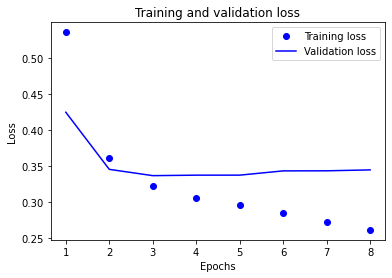

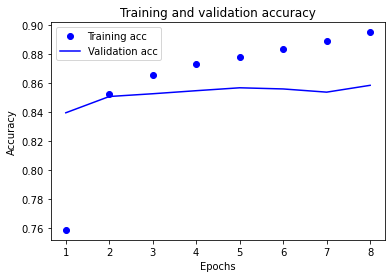

In [21]:
import matplotlib.pyplot as plt
plt.clf()


# loss

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# accuracy

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch = 4일때 Training Loss와 Validation Loss가 둘 다 감소함을 확인  => 7에서 정확도 다시 확인

#### 2) 모델 1

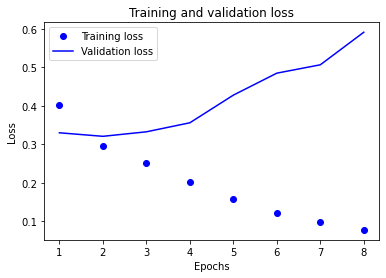

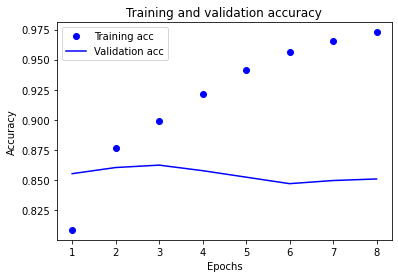

In [22]:
import matplotlib.pyplot as plt
plt.clf()


# loss

acc1 = history1_dict['accuracy']
val_acc1 = history1_dict['val_accuracy']
loss1 = history1_dict['loss']
val_loss1 = history1_dict['val_loss']

epochs1 = range(1, len(acc1) + 1)

plt.plot(epochs1, loss1, 'bo', label='Training loss')
plt.plot(epochs1, val_loss1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# accuracy

plt.plot(epochs1, acc1, 'bo', label='Training acc')
plt.plot(epochs1, val_acc1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch = 2일때 Training Loss와 Validation Loss가 둘 다 감소함을 확인  => 7에서 정확도 다시 확인

#### 3) 모델 2

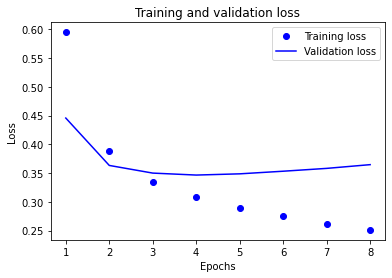

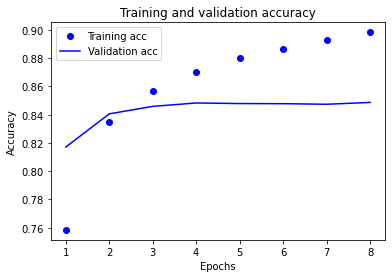

In [23]:
import matplotlib.pyplot as plt
plt.clf()

# loss

acc2 = history2_dict['accuracy']
val_acc2 = history2_dict['val_accuracy']
loss2 = history2_dict['loss']
val_loss2 = history2_dict['val_loss']

epochs2 = range(1, len(acc2) + 1)

plt.plot(epochs2, loss2, 'bo', label='Training loss')
plt.plot(epochs2, val_loss2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# accuracy

plt.plot(epochs2, acc2, 'bo', label='Training acc')
plt.plot(epochs2, val_acc2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch = 3일때 Training Loss와 Validation Loss가 둘 다 감소함을 확인  => 7에서 정확도 다시 확인

## 7. 학습된 Embedding 레이어 분석

#### 1) 모델 0

In [24]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)   

(10000, 16)


##### 모델 다시 쌓기

In [25]:
model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(8))   
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 160,881
Trainable params: 160,881
Non-trainable params: 0
_________________________________________________________________


##### epoch = 4 일때

In [26]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=4 

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/4
266/266 [==============================] - 2s 6ms/step - loss: 0.4807 - accuracy: 0.7864 - val_loss: 0.3532 - val_accuracy: 0.8495
Epoch 2/4
266/266 [==============================] - 1s 5ms/step - loss: 0.3385 - accuracy: 0.8571 - val_loss: 0.3422 - val_accuracy: 0.8509
Epoch 3/4
266/266 [==============================] - 1s 5ms/step - loss: 0.3183 - accuracy: 0.8664 - val_loss: 0.3381 - val_accuracy: 0.8536
Epoch 4/4
266/266 [==============================] - 1s 5ms/step - loss: 0.3078 - accuracy: 0.8714 - val_loss: 0.3384 - val_accuracy: 0.8533


# 모델 0 최종결과

In [27]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3536 - accuracy: 0.8467
[0.35356831550598145, 0.8466545939445496]


#### 2) 모델 1

In [28]:
embedding_layer1 = model1.layers[0]
weights1 = embedding_layer1.get_weights()[0]
print(weights1.shape)    

(10000, 16)


##### 모델 다시 쌓기

In [29]:
model1 = keras.Sequential()
model1.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model1.add(keras.layers.Conv1D(1024, 7, activation='relu'))
model1.add(keras.layers.MaxPooling1D(5))
model1.add(keras.layers.Conv1D(512, 7, activation='relu'))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(128, activation='relu'))
model1.add(keras.layers.Dense(1, activation='sigmoid')) 

model1.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 1024)        115712    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 1024)        0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 512)         3670528   
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

##### epoch = 2 일때

In [30]:
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=2  

history1 = model1.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=512,
                     validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/2
266/266 [==============================] - 8s 29ms/step - loss: 0.4042 - accuracy: 0.8074 - val_loss: 0.3293 - val_accuracy: 0.8590
Epoch 2/2
266/266 [==============================] - 7s 28ms/step - loss: 0.3041 - accuracy: 0.8710 - val_loss: 0.3156 - val_accuracy: 0.8630


# 모델 1 최종결과

In [31]:
results1 = model1.evaluate(X_test,  y_test, verbose=2)

print(results1)

1537/1537 - 6s - loss: 0.3282 - accuracy: 0.8569
[0.3282223641872406, 0.8568667769432068]


#### 3) 모델 2

In [32]:
embedding_layer2 = model2.layers[0]
weights2 = embedding_layer2.get_weights()[0]
print(weights2.shape)    

(10000, 16)


##### 모델다시쌓기

In [33]:
model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  

model2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


##### epoch = 3 일때

In [34]:
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
               metrics=['accuracy'])
              
epochs=3 

history2 = model2.fit(partial_X_train,
                     partial_y_train,
                     epochs=epochs,
                     batch_size=512,
                     validation_data=(X_val, y_val),
                     verbose=1)

Epoch 1/3
266/266 [==============================] - 1s 4ms/step - loss: 0.5769 - accuracy: 0.7356 - val_loss: 0.4237 - val_accuracy: 0.8286
Epoch 2/3
266/266 [==============================] - 1s 4ms/step - loss: 0.3738 - accuracy: 0.8427 - val_loss: 0.3542 - val_accuracy: 0.8437
Epoch 3/3
266/266 [==============================] - 1s 4ms/step - loss: 0.3231 - accuracy: 0.8638 - val_loss: 0.3451 - val_accuracy: 0.8496


# 모델 2 최종결과

In [35]:
results2 = model2.evaluate(X_test,  y_test, verbose=2)

print(results2)

1537/1537 - 2s - loss: 0.3591 - accuracy: 0.8423
[0.3590756058692932, 0.8423418998718262]


## 8. gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩 비교하기

### 1-1) 자체학습 word_vector를 파일에 기록하기

In [36]:
import os
 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim)) 

vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

### 1-2) 자체학습 '사랑'이란 단어 word_vector 확인

In [37]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['사랑']
vector

array([ 0.05193673,  0.03213548, -0.13550033, -0.10654616,  0.12061486,
       -0.12672207, -0.1552918 ,  0.08532712, -0.05959034,  0.06892931,
        0.11422092, -0.11012135, -0.07107305,  0.08158287, -0.07295217,
        0.12409806], dtype=float32)

### 1-3) 자체학습 '재미'라는 단어 유사도 찾기

In [38]:
word_vectors.similar_by_word("재미")

[('이것', 0.7326077818870544),
 ('생활', 0.7290607690811157),
 ('창고', 0.706815242767334),
 ('조', 0.7066009640693665),
 ('""', 0.6798052191734314),
 ('살해', 0.675998866558075),
 ('옆', 0.668594241142273),
 ('복습', 0.668001651763916),
 ('가방', 0.6677492260932922),
 ('아닌가', 0.6579674482345581)]

### 2-1) 사전학습 '사랑'라는  word_vector 확인

In [39]:
from gensim.models import KeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.vec'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=False, limit=1000000)
vector = word2vec['사랑']
vector     

array([ 7.2242e-02, -6.9223e-02,  2.6350e-01,  2.6930e-02,  2.7465e-01,
       -5.7484e-02,  1.1657e-01, -1.0736e-01,  2.6542e-01, -1.5600e-01,
        4.8601e-01,  6.3728e-01,  5.7949e-01,  2.1420e-01, -3.2206e-02,
       -9.1503e-03,  2.0928e-01, -8.1857e-02, -2.6783e-01, -2.5602e-01,
        1.4733e-01,  4.5259e-01,  3.6965e-01,  2.4644e-01, -4.4918e-02,
       -6.7232e-02,  3.1724e-02,  3.3469e-01,  2.6623e-01, -1.1605e-01,
       -1.5161e-02,  1.0318e-01,  1.4193e-01, -7.9796e-02,  1.5111e-02,
        1.0474e-01, -2.3739e-01, -1.1473e-01, -5.4767e-02,  8.9843e-02,
        3.1133e-01,  3.2850e-01,  9.2288e-02, -1.3007e-01, -4.7345e-01,
       -4.1861e-01, -2.1817e-01, -1.6687e-02,  3.4634e-01,  1.1898e-01,
        2.5232e-01,  5.3454e-03,  9.8491e-02,  1.4123e-01,  2.8660e-02,
       -1.1567e-01,  5.5575e-01, -1.4759e-01,  2.7344e-01, -2.9719e-01,
        7.8230e-02, -2.1698e-01, -1.9905e-01,  3.0314e-01, -4.5031e-02,
        1.6996e-01, -3.5892e-01, -2.6847e-01,  1.4510e-01, -2.09

### 2-2) 사전학습 '재미'라는 단어 유사도 찾기

In [40]:
word2vec.similar_by_word("재미")

[('재미있', 0.54170823097229),
 ('흥미', 0.5022858381271362),
 ('한국인', 0.5001272559165955),
 ('교포', 0.48998966813087463),
 ('재밌', 0.45642775297164917),
 ('팬클럽', 0.44300568103790283),
 ('동포', 0.4352205991744995),
 ('공감', 0.43383824825286865),
 ('인기도', 0.43197959661483765),
 ('유머', 0.43098777532577515)]

## 9. 한국어 Word2Vec 임베딩 활용하여 성능개선

### 1) 어휘사전 구축

In [41]:
vocab_size = 10000    
word_vector_dim = 200  

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

### 2) 모델 구성 후 카피한 임베딩 활용!

In [42]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 200  


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))  
model.add(keras.layers.Conv1D(1024, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(512, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 1024)          1434624   
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 1024)           0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 512)            3670528   
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                

### 3) 학습의 진행

In [43]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
             metrics=['accuracy'])
              
epochs=8  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/8
266/266 [==============================] - 21s 80ms/step - loss: 0.4810 - accuracy: 0.7567 - val_loss: 0.3626 - val_accuracy: 0.8432
Epoch 2/8
266/266 [==============================] - 17s 63ms/step - loss: 0.3299 - accuracy: 0.8580 - val_loss: 0.3337 - val_accuracy: 0.8576
Epoch 3/8
266/266 [==============================] - 16s 61ms/step - loss: 0.2865 - accuracy: 0.8797 - val_loss: 0.3257 - val_accuracy: 0.8601
Epoch 4/8
266/266 [==============================] - 17s 62ms/step - loss: 0.2364 - accuracy: 0.9051 - val_loss: 0.3442 - val_accuracy: 0.8512
Epoch 5/8
266/266 [==============================] - 16s 62ms/step - loss: 0.1867 - accuracy: 0.9274 - val_loss: 0.3890 - val_accuracy: 0.8540
Epoch 6/8
266/266 [==============================] - 17s 65ms/step - loss: 0.1425 - accuracy: 0.9461 - val_loss: 0.4574 - val_accuracy: 0.8497
Epoch 7/8
266/266 [==============================] - 17s 62ms/step - loss: 0.1091 - accuracy: 0.9600 - val_loss: 0.5238 - val_accuracy: 0.8455

### 4) epoch에 따른 그래프를 그려볼 수 있는 항목들

In [44]:
history_dict = history.history
print(history_dict.keys()) 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


### 5) loss와 accuracy 그래프화

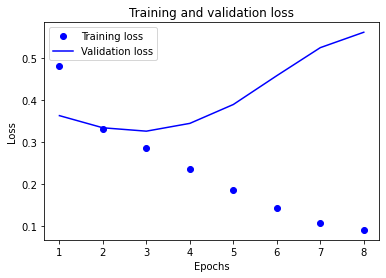

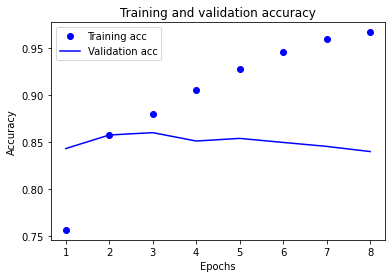

In [45]:
import matplotlib.pyplot as plt
plt.clf()


# loss

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# accuracy

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


Epoch = 4일때 Training Loss와 Validation Loss가 둘 다 감소함을 확인  => 7에서 정확도 다시 확인

### 6) 학습된 Embedding 레이어 분석

In [46]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)   

(10000, 200)


##### 모델다시쌓기

In [47]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 200  


model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))  
model.add(keras.layers.Conv1D(1024, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(512, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 35, 1024)          1434624   
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 1024)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 512)            3670528   
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

###### epoch = 3일때

In [48]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
             metrics=['accuracy'])
              
epochs=3  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/3
266/266 [==============================] - 17s 63ms/step - loss: 0.4957 - accuracy: 0.7519 - val_loss: 0.3513 - val_accuracy: 0.8419
Epoch 2/3
266/266 [==============================] - 17s 63ms/step - loss: 0.3321 - accuracy: 0.8567 - val_loss: 0.3267 - val_accuracy: 0.8559
Epoch 3/3
266/266 [==============================] - 17s 63ms/step - loss: 0.2890 - accuracy: 0.8785 - val_loss: 0.3256 - val_accuracy: 0.8587


# 한국어 word2vec 모델 최종결과

In [49]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3414 - accuracy: 0.8518
[0.3413662910461426, 0.8518217206001282]


### 1) 회고
- 느낀점
처음에 데이터 로더를 구성하는데 있어서 예시답안이 있는줄 모르고 매우 헤매었다.
며칠을 고생하다가 팀방에서 얘기를 나눠보니 데이터 로더 예시답안이 있다는 것을 알게 되었다.
이미 흥미가 떨어진 상태에서 해야한다는 압박만 남은채 진행하여 개인적으로 매우 힘든 노드였다.

<br/>

- Load_data부분의 어려움
아직까지 이 부분을 혼자서 코딩으로 설계하기에는 어려운 것 같다. 함수 안에 들어가 있는 개별적인 부분들을 나눠서 진행하는 것은 어느정도 성공 하였으나 (결측값제거 및 중복제거 등등) 하나로 합쳐서 함수로 하는 과정이 어려웠다. 또한, 이 과정을 제대로 이해하지 못한 부분이 있었던 것 같다.

<br/>

- 한국어 word2vec 파일 다운받고 불러오기의 어려움
직접 만드신 분의 github에서 다운 받으려고 하니 어떤 파일을 다운을 받아야 하는지 어려웠다. 하지만, 여러 나라의 단어들로 구성된 것 중 한국어로 된 것들만 전부 다운 받아서 분석하여 알 수 있었다. 어렵다고 생각해서 멈추는 것이 아니라 직접 행동으로 옮겨야 할 때가 있음을 알 수 있었다.

### 2) 분석
- 앞선 3개의 모델 분석
    - 모델 0은 RNN에서 가장 흔히 LSTM을 활용하여 분석하였다. epoch가 4일 때 training loss와 validation loss가 최소였다. 이때의 Accuray를 구하기 위해 모델을 다시 적합하고 실행하였다. 그 결과 Accuracy 값이 최종적으로 0.8467가 나왔다.
    - 모델 1은 CNN을 활용하여 분석하였다. epoch가 2일 때 training loss와 validation loss가 최소였다. 이때의 Accuray를 구하기 위해 모델을 다시 적합하고 실행하였다. 그 결과 Accuracy 값이 최종적으로 0.8569가 나왔다.
    - 모델 2는 CNN에서 GlobalMaxPooling1D()인 방법을 활용하여 분석하였다. epoch가 3일 때 training loss와 validation loss가 최소였다. 이때의 Accuray를 구하기 위해 모델을 다시 적합하고 실행하였다. 그 결과 Accuracy 값이 최종적으로 0.8423가 나왔다.
    
- 임베딩 레이어를 한국어 word2vec의 것으로 교체한 모델 분석
    - 모델 1(동일한 조건이나 에서 확인한 것)을 활용하여 분석하였다. epoch가 4일 때 training loss와 validation loss가 최소였다. 이때의 Accuray를 구하기 위해 모델을 다시 적합하고 실행하였다. 그 결과 Accuracy 값이 최종적으로 0.8518가 나왔다.
    
- 최종 분석
    - 모델 1과 임베딩 레이어를 한국어 word2vec의 것으로 교체한 모델이나 같은 모델의 조건을 활용하였으나 예상과 달리 모델 1의 accuracy가 더 높았다. 이는 영화리뷰라는 특수한 상황에서는 word2vec을 활용하기보다 영화리뷰 자체로 만든 것을 활용하는 것이 좀 더 좋을 것 같다는 생각을 하였다.

    
    
### 3) 루브릭
- 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
    - 3가지 이상의 모델이 성공적으로 시도됨 (4번 ~ 7번 확인)
- gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
    - gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함 (8번 확인)
- 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
    - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함 (9번 확인)





